## Random SVD

In this notebook we focus on singular value approximation using randomised range finder approximation as presented in [1]. First we construct a NN to do digit recognition and we then use TFHessian to compute the full Hessian matrix. In particular first we define the layout of the NN.

In [1]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
import scipy.linalg as spla
%matplotlib notebook
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from random import *
from tqdm.notebook import tqdm

mnist = tf.keras.datasets.mnist 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("In the training set there are {} images, of size {}x{}."
      .format(train_images.shape[0],train_images.shape[1],train_images.shape[2]))
print("The data are labeled in the following categories, {}"
      .format(train_labels))
#We normalize the dataset
train_images = train_images/255.0
test_images = test_images/255.0
#We assemble the data set
# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

#Keras Sequential allow us to place one layer after the other
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),#Vectorifying layer
    tf.keras.layers.Dense(15, activation='sigmoid'),#128 weights layer
    tf.keras.layers.Dense(10)#10 leyers weights.
])

print("Number of trainable layers {}".format(len(model.trainable_weights)))
print("Number of weights trainable per layer 0, {}".format(model.trainable_weights[0].shape))
print("Number of weights trainable per layer 1, {}".format(model.trainable_weights[1].shape))
print("Number of weights trainable per layer 2, {}".format(model.trainable_weights[2].shape))
print("Number of weights trainable per layer 3, {}".format(model.trainable_weights[3].shape))

In the training set there are 60000 images, of size 28x28.
The data are labeled in the following categories, [5 0 4 ... 5 6 8]
Number of trainable layers 4
Number of weights trainable per layer 0, (784, 15)
Number of weights trainable per layer 1, (15,)
Number of weights trainable per layer 2, (15, 10)
Number of weights trainable per layer 3, (10,)


We now proceed to train the neural network using a sthocastic gradient descent method.

In [2]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
#Importing a lost function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#Defining number of iterations
epochs = 21
for epoch in tqdm(range(epochs)):
    # Iterate over the batches of the dataset.
    for step, (batch_train_images, batch_train_labels) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(batch_train_images, training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(batch_train_labels, logits)
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)
                
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # Update training metric.
        train_acc_metric.update_state(batch_train_labels, logits)
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for batch_test_images, batch_test_labels in test_dataset:
        test_logits = model(batch_test_images, training=False)
        # Update val metrics
        test_acc_metric.update_state(batch_test_labels, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
print("Validation acc: %.4f" % (float(test_acc),))

  0%|          | 0/21 [00:00<?, ?it/s]

Validation acc: 0.7308


In [3]:
def Loss(weights):
    logits = model(batch_train_images, training=True) #Logits for this minibatch
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(batch_train_labels, logits);
    return loss_value;
#We now use TFHessian to compute the Hessian of the NN.
H = Hessian(Loss,model.trainable_weights,"KERAS")
H.SwitchVerbose(True)

In [4]:
matH= H.mat();

MPI the world is 1 process big !


In [5]:
sigmas = spla.svdvals(matH)

<IPython.core.display.Javascript object>


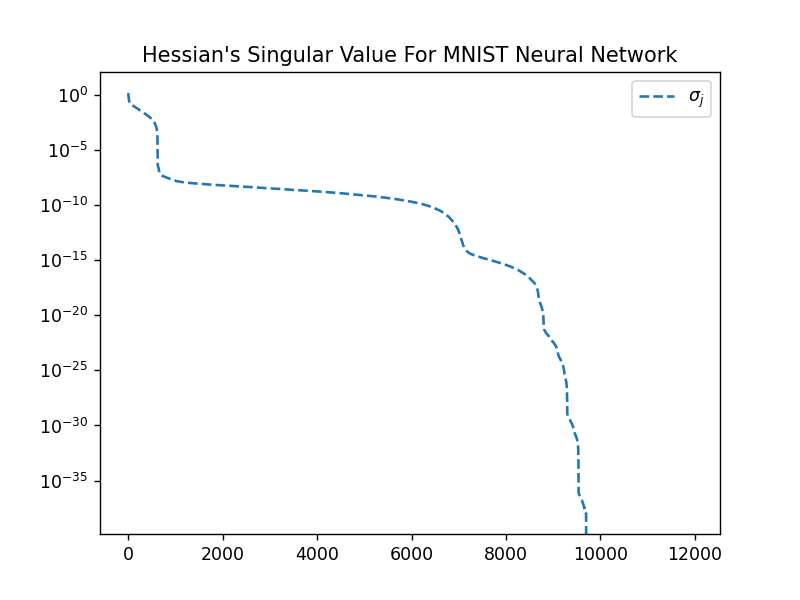

In [19]:
plt.figure()
plt.title("Hessian's Singular Value For MNIST Neural Network")
plt.semilogy(sigmas,"--")
plt.legend([r"$\sigma_j$"])

In [6]:
_,randsigmas,_ = H.RandMatSVD(50,10);

<IPython.core.display.Javascript object>


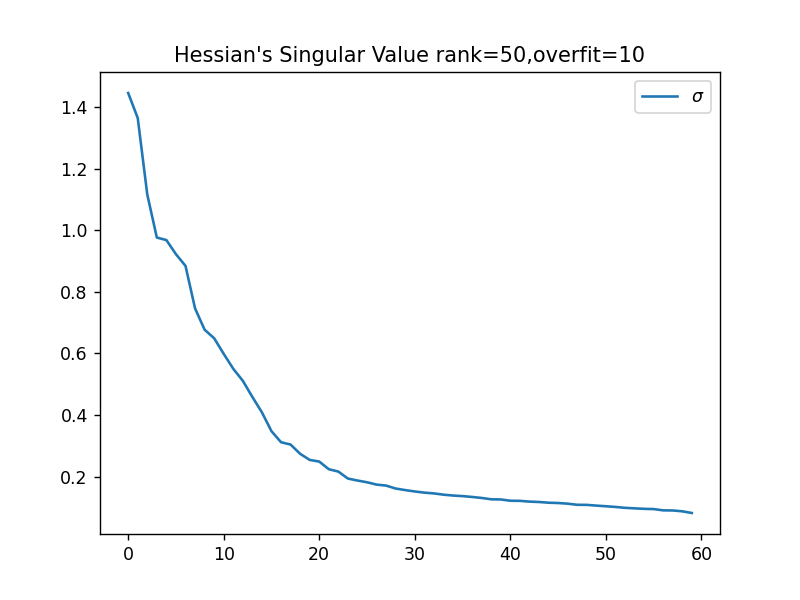

<IPython.core.display.Javascript object>


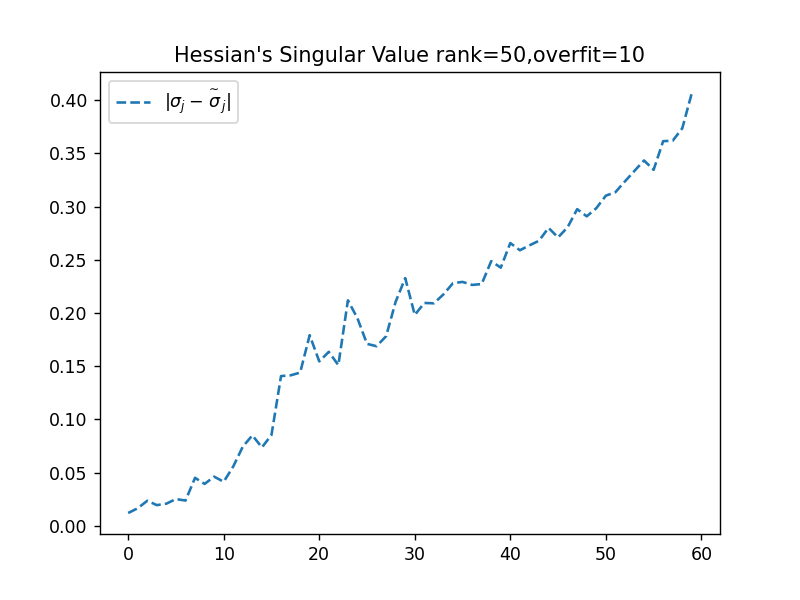

In [10]:
plt.figure()
plt.title("Hessian's Singular Value rank=50,overfit=10")
plt.plot(randsigmas)
plt.legend([r"$\sigma$",r"$\overset{\sim}{\sigma}$"])
plt.show()
plt.figure()
plt.title("Hessian's Singular Value rank=50,overfit=10")
plt.plot([abs((randsigmas[i]-sigmas[i])/sigmas[i]) for i in range(len(randsigmas))],"--")
plt.legend([r"$|\sigma_j-\overset{\sim}{\sigma}_j|$"])